In [1]:
from src.datasets import AugmentedSpeechDataset
from src.utils import checkpoint
from src.utils.notebook import Sampler, visualize_audio 

In [2]:
dataset = AugmentedSpeechDataset(train=False, quiet=True)

In [23]:
# CHECKPOINT = 'wave-u-net-new-baseline-1573165774.full.ckpt'  # GAN + FL baseline 6 epochs
# CHECKPOINT = 'wave-u-net-mse-gan-feature-losses-1573190574.full.ckpt' # GAN + FL + MSE 6 epochs 
CHECKPOINT = 'wave-u-net-mse-onlyy-1573200273.full.ckpt' # MSE loss only, 30 epochs
# CHECKPOINT = 'wave-u-net-feature-loss-only-1573192123.full.ckpt' # FL only, 12 epochs

In [24]:
net = checkpoint.load(CHECKPOINT, use_cuda=False)
net = net.eval()
sampler = Sampler(net, dataset)

In [25]:
# DOWNLOAD = '/home/matt/Downloads/indicator.resampled.wav'
# noisy_arr, pred_clean, pred_noise = get_results_from_file(DOWNLOAD, start=0)#2**18)

In [32]:
noisy_arr, clean_arr, pred_clean, pred_noise, true_noise = sampler.get_results(2)

Predicted clean signal


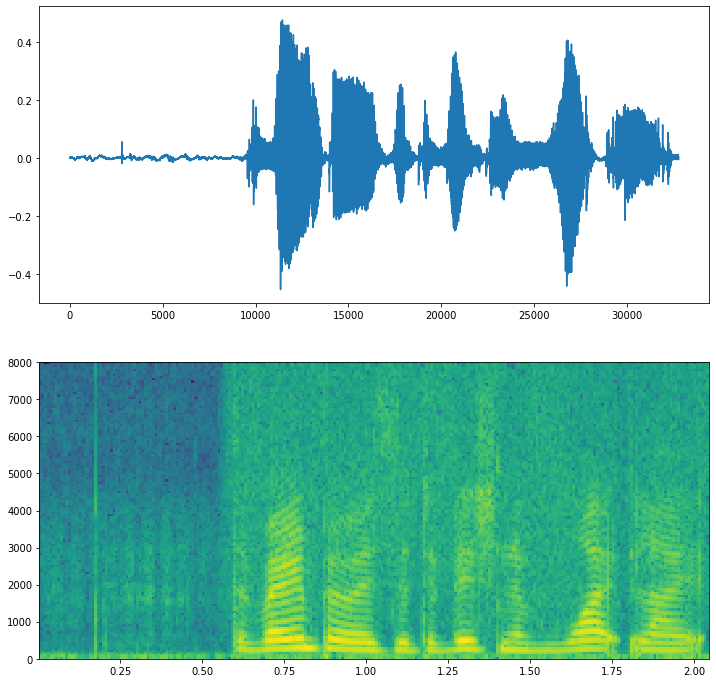

In [33]:
visualize_audio(pred_clean, 'Predicted clean signal')

Clean signal


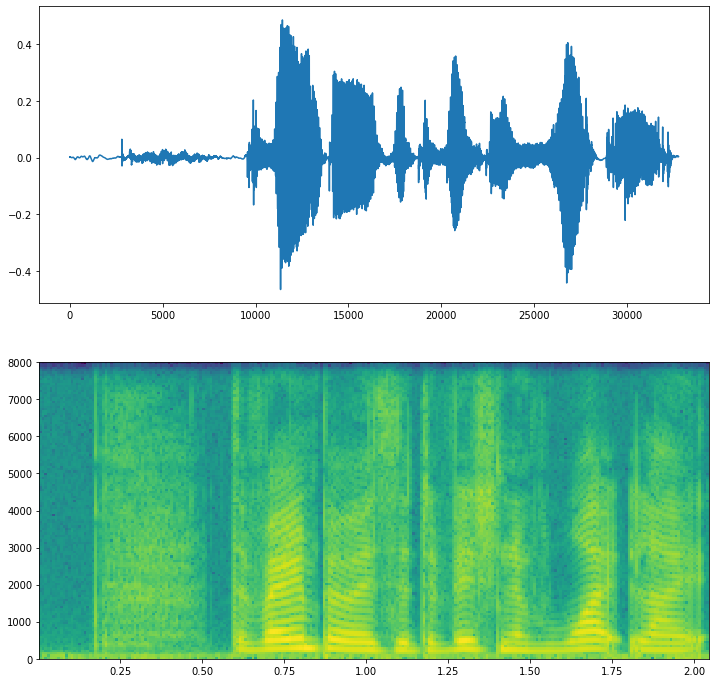

In [34]:
visualize_audio(clean_arr, 'Clean signal')

Noisy signal


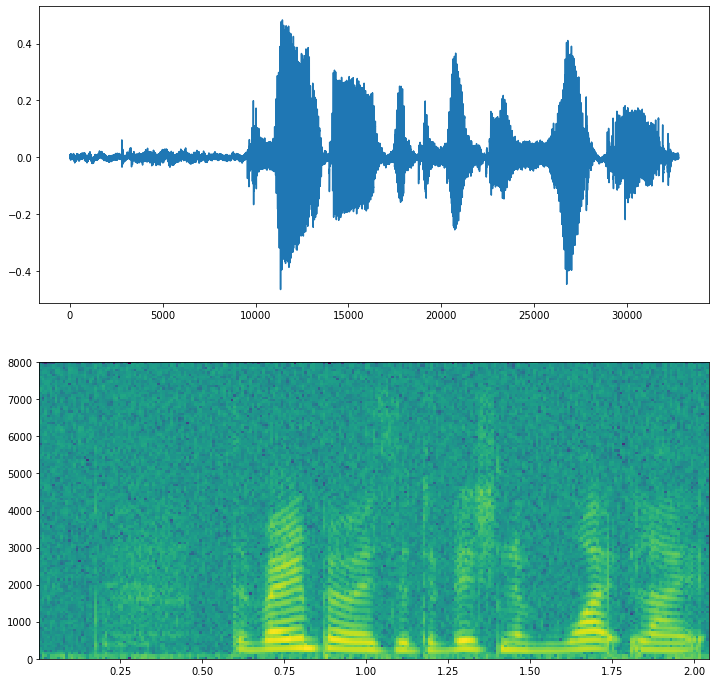

In [35]:
visualize_audio(noisy_arr, 'Noisy signal')

Predicted noise


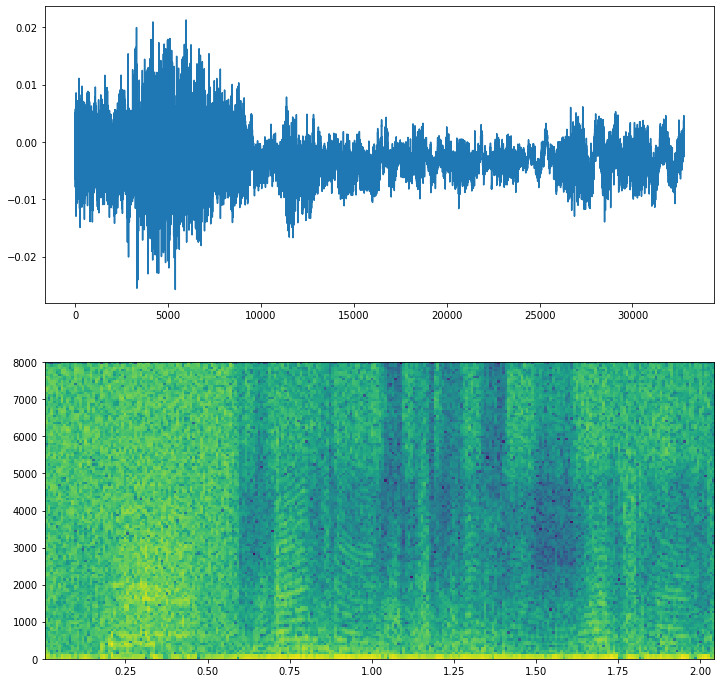

In [36]:
visualize_audio(pred_noise, 'Predicted noise')

True noise signal


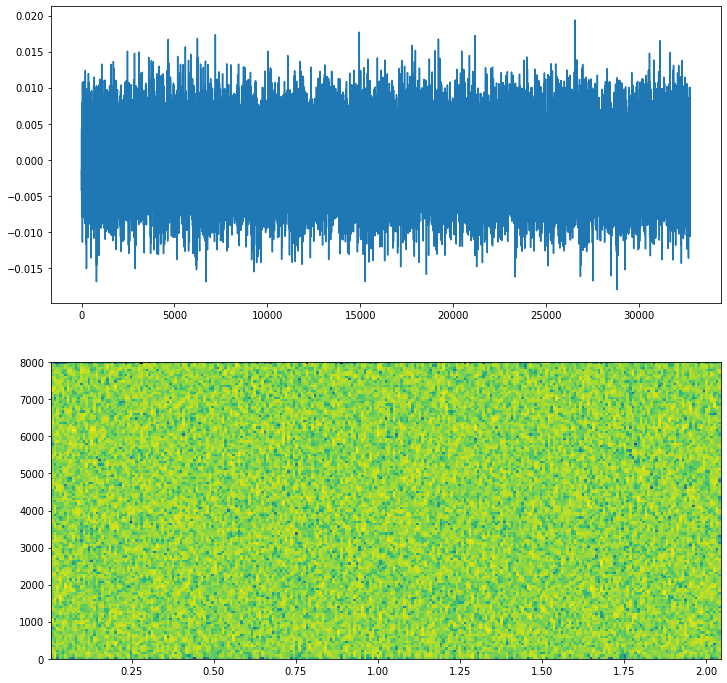

In [37]:
visualize_audio(true_noise, 'True noise signal')